# Transfer learning with YAMNet for environmental sound classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is a pre-trained deep neural network that can predict audio events from [521 classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), such as laughter, barking, or a siren.

 In this tutorial you will learn how to:

- Load and use the YAMNet model for inference.
- Build a new model using the YAMNet embeddings to classify cat and dog sounds.
- Evaluate and export your model.


## Import TensorFlow and other libraries


In [62]:
import os
import zipfile
import csv
import random

In [38]:
from IPython import display

In [39]:
import matplotlib.pyplot as plt

In [40]:
import numpy as np

In [41]:
import pandas as pd

In [42]:
import tensorflow as tf

In [43]:
import tensorflow_hub as hub

In [44]:
import tensorflow_io as tfio

## About YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, you will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. (This is similar to [transfer learning for image classification with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for more information.)

First, you will test the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the `load` function.

Note: to read the documentation of the model, use the model URL in your browser.

In [45]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2023-07-15 13:52:17.814050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int32 and shape [?]
	 [[{{node inputs_3}}]]
2023-07-15 13:52:17.818737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [3]
	 [[{{node inputs_1}}]]
2023-07-15 13:52:17.819083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [3]
	 [[{{node inputs_1}}]]
2023-07-15 13:52

With the model loaded, you can follow the [YAMNet basic usage tutorial](https://www.tensorflow.org/hub/tutorials/yamnet) and download a sample WAV file to run the inference.


In [46]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

./test_data/miaow_16k.wav


You will need a function to load audio files, which will also be used later when working with the training data. (Learn more about reading audio files and their labels in [Simple audio recognition](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels).

Note: The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in the `[-1.0, 1.0]` range (for more information, go to [YAMNet's documentation on TF Hub](https://tfhub.dev/google/yamnet/1)).

In [47]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

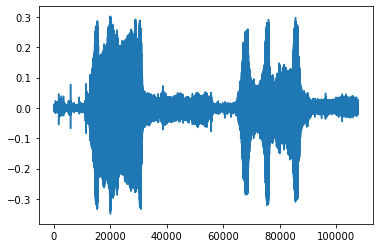

In [48]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

### Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at `yamnet_model.class_map_path()` in the CSV format.

In [49]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.


In [50]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

2023-07-15 13:52:26.196736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'waveform' with dtype float and shape [?]
	 [[{{node waveform}}]]


The main sound is: Animal
The embeddings shape: (13, 1024)


Note: The model correctly inferred an animal sound. Your goal in this tutorial is to increase the model's accuracy for specific classes. Also, notice that the model generated 13 embeddings, 1 per frame.

## ESC-50 dataset

The [ESC-50 dataset](https://github.com/karolpiczak/ESC-50#repository-content) ([Piczak, 2015](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)) is a labeled collection of 2,000 five-second long environmental audio recordings. The dataset consists of 50 classes, with 40 examples per class.

Download the dataset and extract it.


In [36]:
_ = tf.keras.utils.get_file('dev_data_pump.zip',
                        'https://zenodo.org/record/3678171/files/dev_data_pump.zip?download=1',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

1031279015/1031279015 [==============================] - 63s 0us/step


### Explore the data

The metadata for each file is specified in the csv file at `./datasets/ESC-50-master/meta/esc50.csv`

and all the audio files are in `./datasets/ESC-50-master/audio/`

You will create a pandas `DataFrame` with the mapping and use that to have a clearer view of the data.


Hier wird vorher noch eine csv Datei erstellt.
Es wird auch noch eine fold Spalte hinzugefügt für das Cross Validation Verfahren, wo alle Daten in gleichgroße Teilmengen aufgeteilt werden.

In [68]:
# Pfad zum Verzeichnis mit den Audiodateien
audio_dir = './datasets/pump/test'

# Anzahl der Folds für das Cross-Validation-Verfahren
num_folds = 5

# Dateinamen und Klassen der Audiodateien
file_data = []

# Durchsuche das Verzeichnis und sammle Dateinamen und Klassen
for filename in os.listdir(audio_dir):
    if filename.endswith('.wav'):  # angenommen, die Audiodateien haben das Format .wav
        if 'normal' in filename:
            file_data.append((filename, 'normal'))
        elif 'anomaly' in filename:
            file_data.append((filename, 'anomaly'))

# Mische die Daten zufällig
random.shuffle(file_data)

# Berechne die Größe der Fold-Teilmengen
fold_size = len(file_data) // num_folds

# Erstelle die Folds
folds = []
for i in range(num_folds):
    fold_start = i * fold_size
    fold_end = (i + 1) * fold_size
    fold_data = file_data[fold_start:fold_end]
    folds.append(fold_data)

# Pfad zur CSV-Datei
csv_file = './datasets/pump/pump.csv'

# Schreibe die Dateinamen, Klassen und Folds in die CSV-Datei
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'category', 'fold'])  # Schreibe die Spaltenüberschriften

    # Schreibe die Daten in die CSV-Datei
    for fold_index, fold_data in enumerate(folds):
        for filename, label in fold_data:
            writer.writerow([filename, label, fold_index + 1])


In [69]:
pump_csv = './datasets/pump/pump.csv'
base_data_path = './datasets/pump/test/'

pd_data = pd.read_csv(pump_csv)
pd_data.head()

,filename,category,fold
0,anomaly_id_02_00000064.wav,anomaly,1
1,anomaly_id_00_00000116.wav,anomaly,1
2,normal_id_02_00000016.wav,normal,1
3,anomaly_id_00_00000073.wav,anomaly,1
4,normal_id_06_00000051.wav,normal,1


### Filter the data

Now that the data is stored in the `DataFrame`, apply some transformations:

- Filter out rows and use only the selected classes - `dog` and `cat`. If you want to use any other classes, this is where you can choose them.
- Amend the filename to have the full path. This will make loading easier later.
- Change targets to be within a specific range. In this example, `dog` will remain at `0`, but `cat` will become `1` instead of its original value of `5`.

In [70]:
my_classes = ['normal', 'anomaly']
map_class_to_id = {'normal':0, 'anomaly':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]  #sucht in der Spalte "category" speziell nach dem Inhalt der Liste my_classes also [dog, cat]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)
print(filtered_pd.columns)

Index(['filename', 'category', 'fold', 'target'], dtype='object')


### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the `fold` column to proper reflect these new rows.

The expanded `fold` column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [71]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [72]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

2023-07-15 14:31:31.652592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype string
	 [[{{node args_0}}]]


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [74]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

2023-07-15 14:40:26.213636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype float and shape [1024]
	 [[{{node args_0}}]]


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Split the data

You will use the `fold` column to split the dataset into train, validation and test sets.

ESC-50 is arranged into five uniformly-sized cross-validation `fold`s, such that clips from the same original source are always in the same `fold` - find out more in the [ESC: Dataset for Environmental Sound Classification](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf) paper.

The last step is to remove the `fold` column from the dataset since you're not going to use it during training.


In [75]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create your model

You did most of the work!
Next, define a very simple [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model with one hidden layer and two outputs to recognize cats and dogs from sounds.


In [76]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [77]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [78]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

2023-07-15 14:40:52.208896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_92' with dtype resource
	 [[{{node Placeholder/_92}}]]
2023-07-15 14:40:52.221175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_82' with dtype resource
	 [[{{node Placeholder/_82}}]]


Epoch 1/20
    315/Unknown - 179s 530ms/step - loss: 0.6727 - accuracy: 0.5742

2023-07-15 14:43:52.308608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_94' with dtype resource
	 [[{{node Placeholder/_94}}]]
2023-07-15 14:43:52.342532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_254' with dtype resource
	 [[{{node Placeholder/_254}}]]


321/321 [==============================] - 181s 526ms/step - loss: 0.6721 - accuracy: 0.5749 - val_loss: 0.7002 - val_accuracy: 0.5526
Epoch 2/20
321/321 [==============================] - 2s 5ms/step - loss: 0.6608 - accuracy: 0.6052 - val_loss: 0.7142 - val_accuracy: 0.5658
Epoch 3/20
321/321 [==============================] - 2s 6ms/step - loss: 0.6585 - accuracy: 0.6106 - val_loss: 0.7089 - val_accuracy: 0.5690
Epoch 4/20
321/321 [==============================] - 2s 7ms/step - loss: 0.6490 - accuracy: 0.6212 - val_loss: 0.7218 - val_accuracy: 0.5658
Epoch 5/20
321/321 [==============================] - 2s 6ms/step - loss: 0.6435 - accuracy: 0.6281 - val_loss: 0.8102 - val_accuracy: 0.5529
Epoch 6/20
321/321 [==============================] - 2s 6ms/step - loss: 0.6418 - accuracy: 0.6322 - val_loss: 0.7059 - val_accuracy: 0.5760
Epoch 7/20
321/321 [==============================] - 1s 4ms/step - loss: 0.6411 - accuracy: 0.6309 - val_loss: 0.6948 - val_accuracy: 0.5789
Epoch 8/20
32

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [79]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

2023-07-15 14:44:56.178524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_179' with dtype resource
	 [[{{node Placeholder/_179}}]]
2023-07-15 14:44:56.229879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_70' with dtype resource
	 [[{{node Placeholder/_70}}]]


107/107 [==============================] - 1s 3ms/step - loss: 0.6908 - accuracy: 0.6009
Loss:  0.6908293962478638
Accuracy:  0.6008771657943726


You did it!

## Test your model

Next, try your model on the embedding from the previous test using YAMNet only.


In [80]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: normal


## Save a model that can directly take a WAV file as input

Your model works when you give it the embeddings as input.

In a real-world scenario, you'll want to use audio data as a direct input.

To do that, you will combine YAMNet with your model into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving (which you will learn about later in the tutorial), you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies `reduce_mean` and call it `'classifier'`.


In [81]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [84]:
saved_model_path = './pump_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

2023-07-15 14:46:04.300842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int32 and shape [?]
	 [[{{node inputs_3}}]]
2023-07-15 14:46:04.303143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [3]
	 [[{{node inputs_1}}]]
2023-07-15 14:46:04.303270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [3]
	 [[{{node inputs_1}}]]
2023-07-15 14:46

2023-07-15 14:46:08.338495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'waveform' with dtype float and shape [?]
	 [[{{node waveform}}]]
2023-07-15 14:46:08.404442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?]
	 [[{{node Placeholder}}]]
2023-07-15 14:46:08.513826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'waveform' with dtype float and shape [?]
	 [[{{node waveform}}]]
2023-07-15

INFO:tensorflow:Assets written to: ./pump_yamnet/assets


INFO:tensorflow:Assets written to: ./pump_yamnet/assets


In [85]:
tf.keras.utils.plot_model(serving_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Load your saved model to verify that it works as expected.

In [86]:
reloaded_model = tf.saved_model.load(saved_model_path)

2023-07-15 14:46:22.523447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [2]
	 [[{{node inputs_1}}]]
2023-07-15 14:46:22.523551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [2]
	 [[{{node inputs_1}}]]
2023-07-15 14:46:22.717655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [1,2]
	 [[{{node inputs_1}}]]
2023-07-15 14:

And for the final test: given some sound data, does your model return the correct result?

In [87]:
reloaded_results = reloaded_model(testing_wav_data)
normal_or_anomal = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {normal_or_anomal}')

2023-07-15 14:47:05.492981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [107698]
	 [[{{node inputs}}]]


The main sound is: normal


If you want to try your new model on a serving setup, you can use the 'serving_default' signature.

In [90]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {normal_or_anomal}')


The main sound is: normal


## (Optional) Some more testing

The model is ready.

Let's compare it to YAMNet on the test dataset.

./datasets/pump/test/anomaly_id_00_00000136.wav


Waveform values: [-2.3130120e-08  1.1000583e-07 -2.8392608e-07 ... -4.4544945e-03
 -7.4783843e-03 -6.1361357e-03]


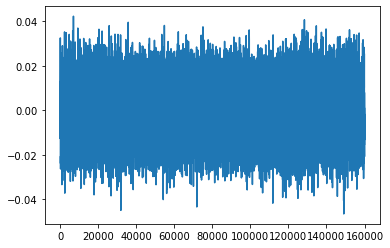

In [91]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [92]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Rain (0.26645299792289734)


2023-07-15 14:48:09.616787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [160000]
	 [[{{node inputs}}]]


[Your model] The main sound is: normal (0.987359344959259)


## Next steps

You have created a model that can classify sounds from dogs or cats. With the same idea and a different dataset you can try, for example, building an [acoustic identifier of birds](https://www.kaggle.com/c/birdclef-2021/) based on their singing.

Share your project with the TensorFlow team on social media!
